# Environment Setup

## Import Libraries

In [14]:
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Import Data

In [15]:
train_sparse_matrix = pd.read_pickle(
    '../data/processed/train_sparse_matrix.pkl')
test_sparse_matrix = pd.read_pickle(
    '../data/processed/test_sparse_matrix.pkl')

# Model Training & Evaluation

In [16]:
train_sparse_matrix.shape, test_sparse_matrix.shape

((4448, 12410), (4448, 12410))

In [17]:
def train_svd_model(train_matrix, test_matrix, k=20):
    train_matrix = train_matrix.astype(np.float32)
    test_matrix = test_matrix.astype(np.float32)
    u, s, vt = svds(train_matrix, k=k)
    s_matrix = np.diag(s)
    svd_model = {"u": u, "s": s_matrix, "vt": vt}
    reconstructed_train_matrix = np.dot(np.dot(u, s_matrix), vt)
    y_train_true = np.squeeze(train_matrix[train_matrix.nonzero()].A)
    y_train_pred = np.squeeze(
        reconstructed_train_matrix[train_matrix.nonzero()])
    train_rmse = mean_squared_error(y_train_true, y_train_pred, squared=False)
    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    reconstructed_test_matrix = reconstructed_train_matrix
    y_test_true = np.squeeze(test_matrix[test_matrix.nonzero()].A)
    y_test_pred = np.squeeze(reconstructed_test_matrix[test_matrix.nonzero()])
    test_rmse = mean_squared_error(y_test_true, y_test_pred, squared=False)
    test_mae = mean_absolute_error(y_test_true, y_test_pred)
    return svd_model, {"Train RMSE": train_rmse, "Train MAE": train_mae, "Test RMSE": test_rmse, "Test MAE": test_mae}

In [18]:
def train_knn_model(train_matrix, test_matrix, n_neighbors=5):
    model_knn = NearestNeighbors(
        metric='cosine', algorithm='brute', n_neighbors=n_neighbors)
    model_knn.fit(train_matrix)
    y_train_pred = np.zeros(train_matrix.shape)
    for i in range(train_matrix.shape[0]):
        distances, indices = model_knn.kneighbors(train_matrix.getrow(
            i).toarray().reshape(1, -1), return_distance=True)
        distances = distances.flatten()
        indices = indices.flatten()
        weights = 1 / (1 + distances)
        neighbors_data = train_matrix[indices].toarray()
        y_train_pred[i] = np.dot(weights, neighbors_data) / np.sum(weights)
    train_nz_row, train_nz_col = train_matrix.nonzero()
    y_train_true = np.array(train_matrix[train_nz_row, train_nz_col]).flatten()
    non_zero_train_pred = np.array(
        y_train_pred[train_nz_row, train_nz_col]).flatten()
    train_rmse = mean_squared_error(
        y_train_true, non_zero_train_pred, squared=False)
    train_mae = mean_absolute_error(y_train_true, non_zero_train_pred)
    y_test_pred = np.zeros(test_matrix.shape)
    for i in range(test_matrix.shape[0]):
        distances, indices = model_knn.kneighbors(test_matrix.getrow(
            i).toarray().reshape(1, -1), return_distance=True)
        distances = distances.flatten()
        indices = indices.flatten()
        weights = 1 / (1 + distances)
        neighbors_data = train_matrix[indices].toarray()
        y_test_pred[i] = np.dot(weights, neighbors_data) / np.sum(weights)
    test_nz_row, test_nz_col = test_matrix.nonzero()
    y_test_true = np.array(test_matrix[test_nz_row, test_nz_col]).flatten()
    non_zero_test_pred = np.array(
        y_test_pred[test_nz_row, test_nz_col]).flatten()
    test_rmse = mean_squared_error(
        y_test_true, non_zero_test_pred, squared=False)
    test_mae = mean_absolute_error(y_test_true, non_zero_test_pred)
    cosine_similarity = np.mean(1 / (1 + np.array(distances)))
    return model_knn, {"Train RMSE": train_rmse, "Train MAE": train_mae, "Test RMSE": test_rmse, "Test MAE": test_mae, "CosineSimilarity": cosine_similarity}

## SVD Model

In [19]:
svd_model, svd_metrics = train_svd_model(
    train_sparse_matrix, test_sparse_matrix, k=20)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## KNN Model

In [20]:
knn_model, knn_metrics = train_knn_model(
    train_sparse_matrix, test_sparse_matrix, n_neighbors=5)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Model Analysis

## Model Performance Review

In [21]:
models_metrics = pd.DataFrame([svd_metrics, knn_metrics], index=["SVD", "KNN"])
models_metrics

,Train RMSE,Train MAE,Test RMSE,Test MAE,CosineSimilarity
SVD,4.155467,3.666124,4.689598,4.616988,NaN
KNN,2.860363,2.678254,4.072594,3.758719,0.5


## Model Performance Visualization

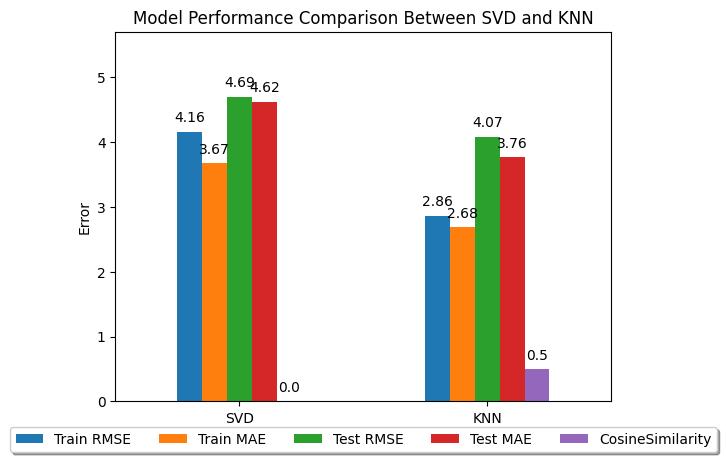

In [22]:
ax = models_metrics.plot(kind='bar')
plt.title("Model Performance Comparison Between SVD and KNN")
plt.ylabel("Error")
plt.xticks(rotation=0)
ylim_max = models_metrics.max().max() + 1
plt.ylim(0, ylim_max)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.legend(loc='upper center', bbox_to_anchor=(
    0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

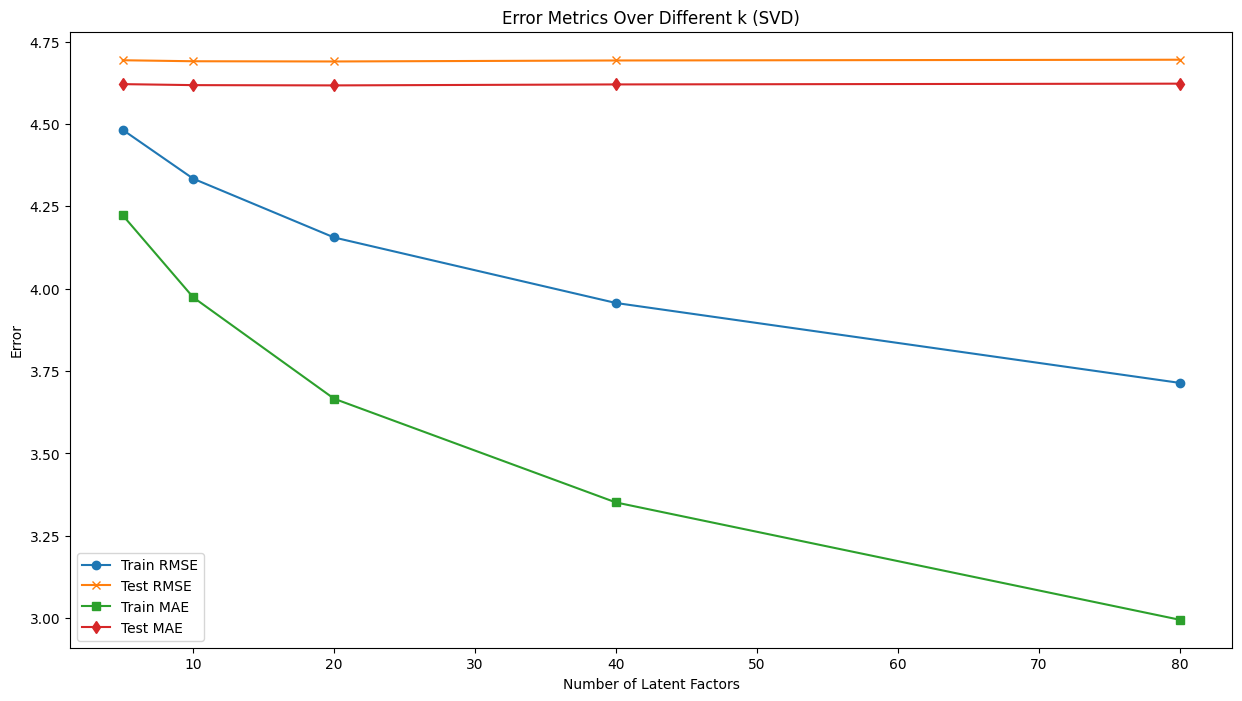

In [23]:
ks = [5, 10, 20, 40, 80]
train_svd_rmse = []
test_svd_rmse = []
train_svd_mae = []
test_svd_mae = []
for k in ks:
    _, metrics = train_svd_model(train_sparse_matrix, test_sparse_matrix, k=k)
    train_svd_rmse.append(metrics["Train RMSE"])
    test_svd_rmse.append(metrics["Test RMSE"])
    train_svd_mae.append(metrics["Train MAE"])
    test_svd_mae.append(metrics["Test MAE"])
plt.figure(figsize=(15, 8))
plt.plot(ks, train_svd_rmse, label="Train RMSE", marker='o')
plt.plot(ks, test_svd_rmse, label="Test RMSE", marker='x')
plt.plot(ks, train_svd_mae, label="Train MAE", marker='s')
plt.plot(ks, test_svd_mae, label="Test MAE", marker='d')
plt.title("Error Metrics Over Different k (SVD)")
plt.xlabel("Number of Latent Factors")
plt.ylabel("Error")
plt.legend()
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

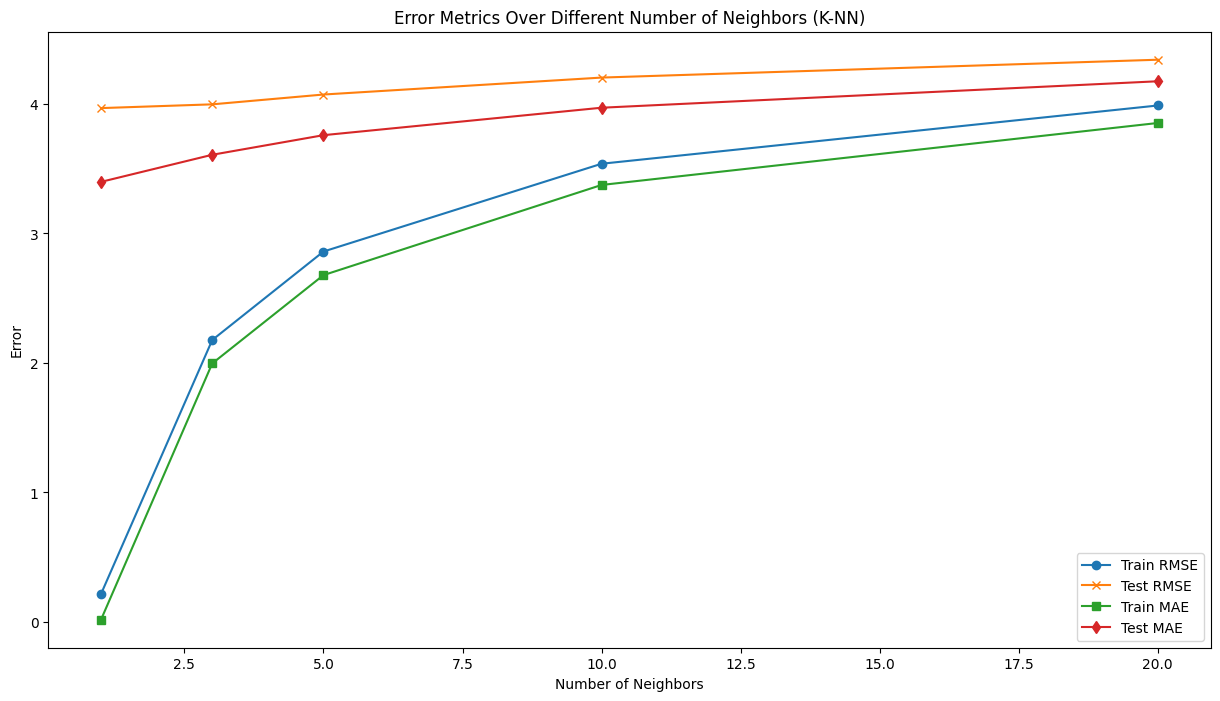

In [24]:
n_neighbors_values = [1, 3, 5, 10, 20]
train_knn_rmse = []
test_knn_rmse = []
train_knn_mae = []
test_knn_mae = []
for n in n_neighbors_values:
    _, metrics = train_knn_model(
        train_sparse_matrix, test_sparse_matrix, n_neighbors=n)
    train_knn_rmse.append(metrics["Train RMSE"])
    test_knn_rmse.append(metrics["Test RMSE"])
    train_knn_mae.append(metrics["Train MAE"])
    test_knn_mae.append(metrics["Test MAE"])
plt.figure(figsize=(15, 8))
plt.plot(n_neighbors_values, train_knn_rmse, label="Train RMSE", marker='o')
plt.plot(n_neighbors_values, test_knn_rmse, label="Test RMSE", marker='x')
plt.plot(n_neighbors_values, train_knn_mae, label="Train MAE", marker='s')
plt.plot(n_neighbors_values, test_knn_mae, label="Test MAE", marker='d')
plt.title("Error Metrics Over Different Number of Neighbors (K-NN)")
plt.xlabel("Number of Neighbors")
plt.ylabel("Error")
plt.legend()
plt.show()

# Export Final Model

In [25]:
with open('../models/final_model.pkl', 'wb') as file:
   pickle.dump(knn_model, file)